
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/063_Diffusion_Models_DDPM.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/63_Diffusion_Models_DDPM.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 🌫️ Diffusion Models (DDPM): Matematyka Stable Diffusion

GAN-y (które robiliśmy w notatniku 41) są kapryśne ("wojna sieci").
Modele Dyfuzyjne (Diffusion) są stabilne i oparte na fizyce (termodynamice).

**Idea:**
1.  **Forward Process (Niszczenie):** Bierzemy zdjęcie i w 1000 krokach powoli dodajemy do niego szum Gaussa, aż zostanie sama "śnieżyca". To jest proste matematycznie.
2.  **Reverse Process (Naprawianie):** Uczymy sieć neuronową (zazwyczaj U-Net), żeby przewidziała **tylko ten szum**, który został dodany w ostatnim kroku, i go odjęła.

Jeśli powtórzymy "odszumianie" 1000 razy, zaczynając od losowego szumu -> otrzymamy nowe, wyraźne zdjęcie!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
TIMESTEPS = 200 # Liczba kroków (w prawdziwym Stable Diffusion ok. 1000)
START_BETA = 0.0001
END_BETA = 0.02
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Będziemy niszczyć i naprawiać dane w {TIMESTEPS} krokach.")

Będziemy niszczyć i naprawiać dane w 200 krokach.


## Harmonogram Szumu (Noise Schedule)

Musimy ustalić, ile szumu dodajemy w każdym kroku.
Używamy parametru $\beta$ (beta).
*   $\alpha = 1 - \beta$
*   $\bar{\alpha}$ (alpha bar) = iloczyn wszystkich $\alpha$ do tej pory.

Pozwala to skoczyć od razu do dowolnego kroku $t$ bez pętli:
$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $$
Gdzie $x_0$ to oryginał, a $\epsilon$ to szum.

Harmonogram gotowy.


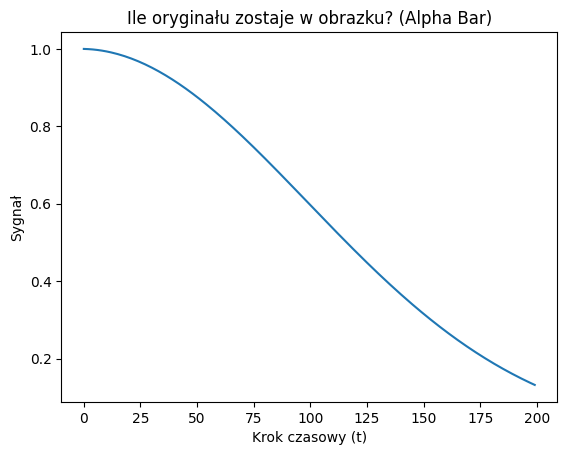

In [2]:
# Definiujemy harmonogram (liniowy)
betas = torch.linspace(START_BETA, END_BETA, TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # Skumulowany iloczyn (alpha bar)

# Funkcja pomocnicza do pobierania wartości w konkretnym czasie t
def get_val_at_t(val, t, x_shape):
    batch_t = t.long()
    out = val.gather(-1, batch_t).float()
    return out.view(-1, *([1] * (len(x_shape) - 1)))

print("Harmonogram gotowy.")
plt.plot(alphas_cumprod)
plt.title("Ile oryginału zostaje w obrazku? (Alpha Bar)")
plt.xlabel("Krok czasowy (t)")
plt.ylabel("Sygnał")
plt.show()

## Forward Diffusion (Niszczenie)

Zobaczmy to na przykładzie.
Weźmiemy "dane" (dla uproszczenia: punkt 2D ułożony w kształt księżyca lub spirali), żeby łatwo to narysować.
Zobaczymy, jak z czasem zmieniają się w chmurę szumu.

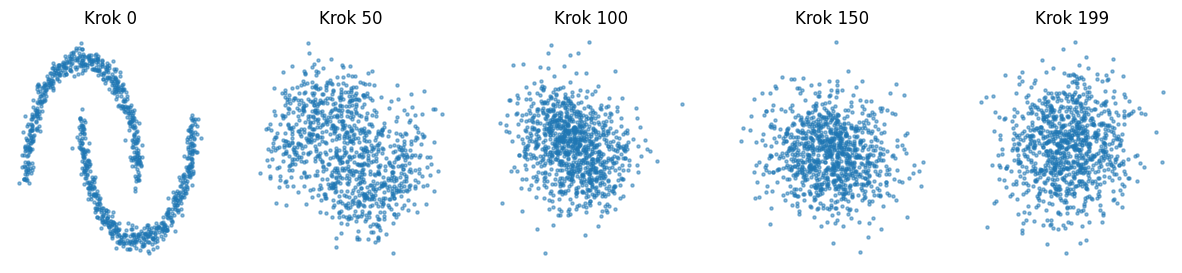

In [3]:
from sklearn.datasets import make_moons

# 1. Dane (Księżyce)
X, _ = make_moons(n_samples=1000, noise=0.05)
X = torch.tensor(X).float()

# Funkcja dodająca szum (Forward)
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    
    sqrt_alphas_cumprod_t = get_val_at_t(torch.sqrt(alphas_cumprod), t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_val_at_t(torch.sqrt(1 - alphas_cumprod), t, x_0.shape)
    
    # Wzór: Sygnał + Szum
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

# Wizualizacja procesu
plt.figure(figsize=(15, 3))
steps_to_show = [0, 50, 100, 150, 199]

for i, t_val in enumerate(steps_to_show):
    t_tensor = torch.full((1000,), t_val) # Wektor czasu
    x_noisy = q_sample(X, t_tensor)
    
    plt.subplot(1, 5, i+1)
    plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=5, alpha=0.5)
    plt.title(f"Krok {t_val}")
    plt.axis("off")
plt.show()

## Reverse Process (Model Odszumiający)

Teraz wytrenujemy prostą sieć (MLP), która dostaje:
1.  Zaszumiony punkt ($x_t$).
2.  Informację, który to krok ($t$).

Jej zadanie: **Przewidzieć szum**, który został dodany.
Jeśli odejmiemy przewidziany szum od $x_t$, zbliżymy się do $x_{t-1}$.

In [6]:
class NoisePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        # Wejście: 2 (współrzędne) + 1 (czas)
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Przewidujemy szum (2D)
        )

    def forward(self, x, t):
        # Normalizujemy czas do 0-1
        t = t.unsqueeze(-1).float() / TIMESTEPS
        x_input = torch.cat([x, t], dim=1)
        return self.net(x_input)

model = NoisePredictor().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# TRENING
print("Start treningu...")
for epoch in range(1000):
    optimizer.zero_grad()
    
    # 1. Losujemy t dla każdego punktu
    t = torch.randint(0, TIMESTEPS, (len(X),)).to(DEVICE)
    
    # 2. Generujemy szum i obrazek zaszumiony
    noise = torch.randn_like(X).to(DEVICE)
    x_noisy = q_sample(X.to(DEVICE), t, noise)
    
    # 3. Model próbuje zgadnąć szum
    predicted_noise = model(x_noisy, t)
    
    # 4. Liczymy błąd (czy dobrze zgadł szum?)
    loss = loss_fn(predicted_noise, noise)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 200 == 0:
        print(f"Epoka {epoch}, Loss: {loss.item():.5f}")

Start treningu...
Epoka 0, Loss: 0.97091
Epoka 200, Loss: 0.39650
Epoka 400, Loss: 0.38908
Epoka 600, Loss: 0.36003
Epoka 800, Loss: 0.38829


## Generowanie (Sampling)

Mamy wytrenowany model. Teraz magia.
1.  Bierzemy czysty szum losowy (Krok 200).
2.  Pytamy model: "Jaki tu jest szum?".
3.  Odejmujemy go (trochę).
4.  Idziemy do kroku 199.
5.  Powtarzamy aż do kroku 0.

Jeśli zadziała, z chaosu powinny wyłonić się dwa księżyce!

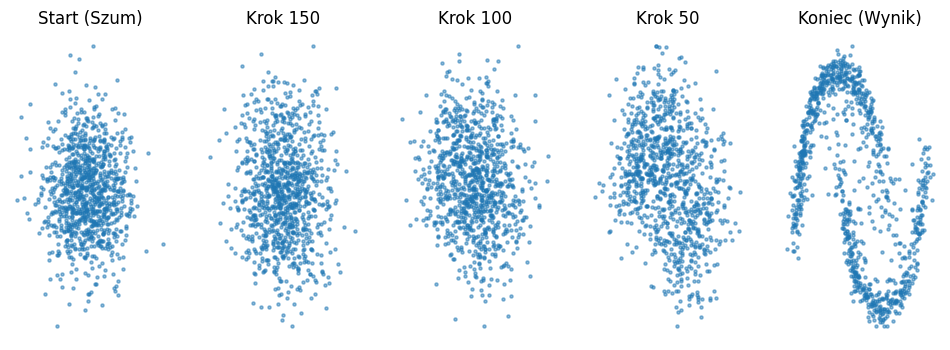

In [7]:
# Zaczynamy od czystego szumu
x_seq = torch.randn(1000, 2).to(DEVICE)
hist = [x_seq.cpu().detach().numpy()]

# Idziemy od T-1 do 0
with torch.no_grad():
    for t in reversed(range(TIMESTEPS)):
        t_tensor = torch.full((1000,), t).to(DEVICE)
        
        # Przewidujemy szum
        pred_noise = model(x_seq, t_tensor)
        
        # Matematyka odszumiania (uproszczona wersja DDPM)
        alpha = alphas[t]
        alpha_hat = alphas_cumprod[t]
        beta = betas[t]
        
        if t > 0:
            noise = torch.randn_like(x_seq)
        else:
            noise = 0
            
        # Odejmujemy przewidziany szum (wzór Langlevina/DDPM)
        x_seq = (1 / torch.sqrt(alpha)) * (x_seq - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) + torch.sqrt(beta) * noise
        
        if t % 50 == 0:
            hist.append(x_seq.cpu().detach().numpy())

# Rysujemy wynik
plt.figure(figsize=(12, 4))
titles = ["Start (Szum)", "Krok 150", "Krok 100", "Krok 50", "Koniec (Wynik)"]
for i, data in enumerate(hist):
    plt.subplot(1, 5, i+1)
    plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.5)
    plt.title(titles[i] if i < len(titles) else "")
    plt.axis("off")
plt.show()

## 🧠 Podsumowanie: Stabilność

Spójrz na ostatni obrazek. Z kompletnego chaosu ułożyły się (mniej więcej) dwa księżyce.

**Dlaczego Dyfuzja wygrała z GAN-ami?**
GAN musiał wymyślić obrazek "na raz". To trudne.
Dyfuzja robi to małymi kroczkami. Łatwiej jest "trochę poprawić zaszumiony obrazek" niż "namalować Monę Lisę z pamięci".

To, co tu zrobiliśmy na punktach 2D, **Stable Diffusion** robi na tensorach obrazów (w przestrzeni ukrytej VAE). Matematyka jest identyczna.